Cashew leaf miner
(400, 400, 3)


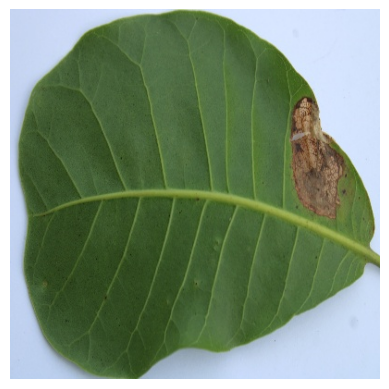

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np



# ! unzip -n ~/code/MahautHDL/save_the_crops/raw_data/crop.zip -d ~/code/MahautHDL/save_the_crops/raw_data

data_link = os.environ.get("LOCAL_PATH")
#data_link = '/Users/thomasverpoort/code/MahautHDL/save_the_crops/raw_data/'
crops = os.listdir(data_link)
plant_disease = np.random.randint(0, len(crops))
plant_disease_name = crops[plant_disease]

os.chdir(f'{data_link}{plant_disease_name}')

link = os.listdir(f"{data_link}{plant_disease_name}")
rand_pic_nr = np.random.randint(0, len(link))

img = plt.imread(link[rand_pic_nr])

print(plant_disease_name)
plt.imshow(img)
plt.axis(False)
print(img.shape)